In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import folium
from shapely.wkt import loads
import numpy as np

In [13]:
df = pd.read_csv('../../data/processed/land_dataset_from_use_lat_lot_getaddr.csv')

In [14]:
df.dropna(inplace=True)

In [15]:
# Convert WKT strings to geometry objects
df['geometry'] = df['geometry'].apply(loads)  # Convert point geometry
df['polygon_geom'] = df['polygon_geom'].apply(loads)  # Convert hexagon geometry

In [16]:
# Create GeoDataFrames
point_gdf = gpd.GeoDataFrame(df, geometry='geometry')
hex_gdf = gpd.GeoDataFrame(df, geometry='polygon_geom')

In [17]:
# Aggregate hexagon data (one row per hexagon)
hex_aggregated = hex_gdf.groupby('h3').agg({
    'population': 'first',
    'ADM3_EN': 'first',
    'ADM2_EN': 'first',
    'ADM1_EN': 'first',
    'polygon_geom': 'first',
    'price_per_m2': 'mean'  # Calculate average price per hexagon
}).reset_index()

In [18]:
# Convert back to GeoDataFrame
hex_gdf = gpd.GeoDataFrame(hex_aggregated, geometry='polygon_geom')

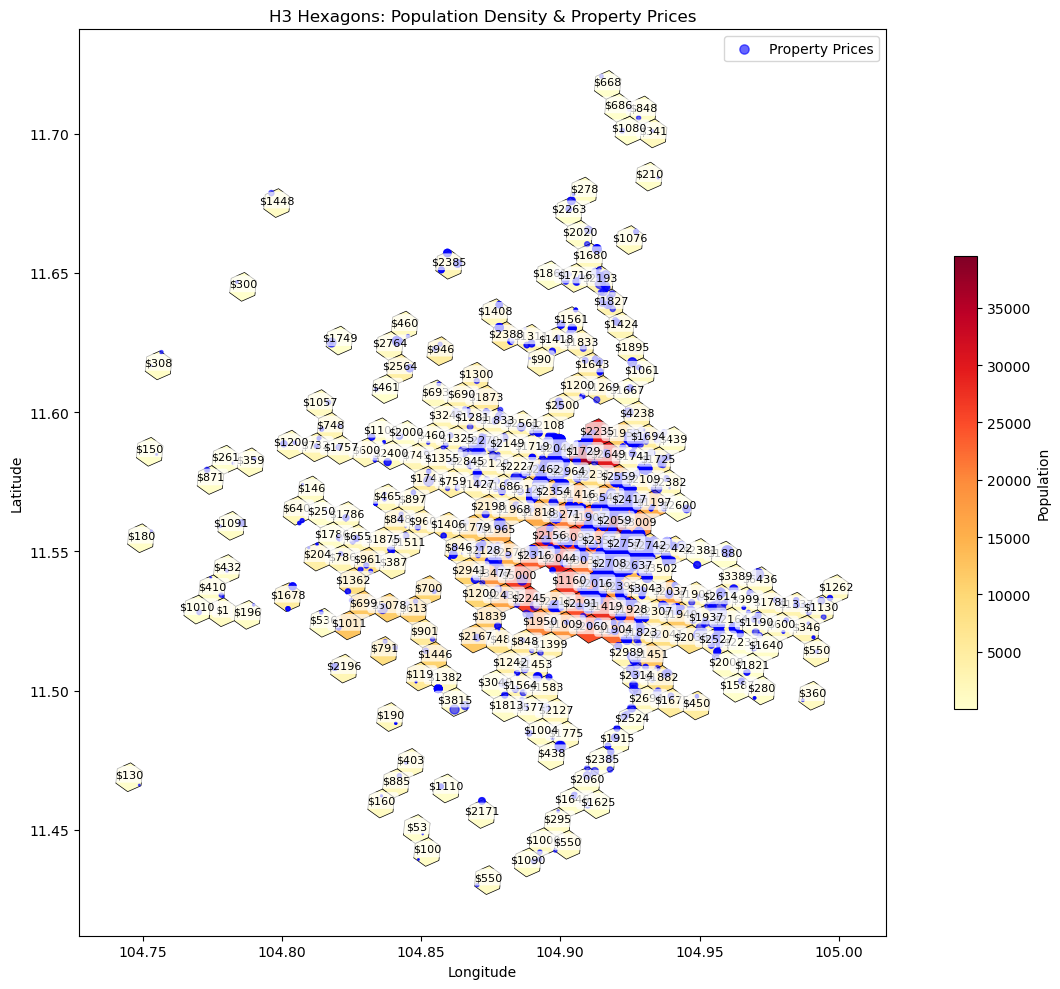

In [19]:
# 1. Create static plot
plt.figure(figsize=(14, 10))
ax = plt.subplot(111)

# Plot hexagons colored by population
hex_gdf.plot(
    ax=ax,
    column='population',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Population", 'shrink': 0.5}
)

# Overlay property prices (size represents price_per_m2)
point_gdf.plot(
    ax=ax,
    markersize=point_gdf['price_per_m2']/100,  # Scale marker size
    color='blue',
    alpha=0.6,
    marker='o',
    label='Property Prices'
)

# Add hexagon labels
for idx, row in hex_gdf.iterrows():
    centroid = row['polygon_geom'].centroid
    plt.annotate(
        text=f"${row['price_per_m2']:.0f}",  # Show avg price
        xy=(centroid.x, centroid.y),
        ha='center',
        fontsize=8,
        color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
    )

plt.title('H3 Hexagons: Population Density & Property Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.savefig('h3_hexagon_analysis.png', dpi=300)
plt.show()

In [20]:
# 2. Create interactive Folium map
print("\nCreating interactive map...")
phnom_penh_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=phnom_penh_center, zoom_start=13, tiles='CartoDB positron')

# Create population colormap
max_pop = hex_gdf['population'].max()
min_pop = hex_gdf['population'].min()
colormap = LinearSegmentedColormap.from_list('pop_cmap', ['yellow', 'orange', 'red'])
norm = plt.Normalize(min_pop, max_pop)

# Add hexagon layer
for idx, row in hex_gdf.iterrows():
    # Convert geometry to Folium format
    if row['polygon_geom'].geom_type == 'MultiPolygon':
        # Take the first polygon from multipolygon
        polygon = row['polygon_geom'].geoms[0]
    else:
        polygon = row['polygon_geom']
    
    # Get coordinates
    coords = list(polygon.exterior.coords)
    coords = [(y, x) for x, y in coords]  # Convert to (lat, lon)
    
    # Get color based on population
    color = plt.cm.YlOrRd(norm(row['population']))
    hex_color = '#%02x%02x%02x' % (
        int(color[0]*255), int(color[1]*255), int(color[2]*255)
    )
    
    # Create popup content
    popup_content = f"""
    <h4>{row['ADM2_EN']} District</h4>
    <b>Commune:</b> {row['ADM3_EN']}<br>
    <b>Hex ID:</b> {row['h3']}<br>
    <b>Population:</b> {row['population']:.0f}<br>
    <b>Avg Price/m²:</b> ${row['price_per_m2']:.0f}
    """
    
    # Add polygon to map
    folium.Polygon(
        locations=coords,
        color='black',
        weight=1,
        fill_color=hex_color,
        fill_opacity=0.7,
        popup=popup_content
    ).add_to(m)

# Add property markers
for idx, row in point_gdf.iterrows():
    popup_content = f"""
    <b>Price:</b> ${row['price']:,.0f}<br>
    <b>Price/m²:</b> ${row['price_per_m2']:,.0f}<br>
    <b>Land Area:</b> {row['land_area']} m²<br>
    <b>Commune:</b> {row['ADM3_EN']}
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5 + row['price_per_m2']/500,  # Scale by price
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=popup_content
    ).add_to(m)

# Add layer control and save
folium.LayerControl().add_to(m)
m.save('h3_interactive_map.html')


Creating interactive map...
